In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
import seaborn as sns
from sklearn import metrics

from copy import deepcopy

import h2o

In [ ]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# 1. Data Overview

In [ ]:
df = pd.read_csv("CLEAN_customer_data_history.csv")

In [ ]:
df.columns

In [ ]:
# Lets delete those strange variables
df = df.drop(["Clientnum"], axis=1)

df.head()

In [ ]:
credit_card_report = ProfileReport(df)

In [ ]:
credit_card_report

**We have to consider that there are many variables that are categorical and we will have to encode them**

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["class"] = le.fit_transform(df["Status"])
df = df.drop("Status", axis=1)

In [ ]:
df["class"].value_counts()

In [ ]:
# Making a copy of the data to save the original data
original_df = deepcopy(df)

In [ ]:
df = deepcopy(original_df)

In [ ]:
# Encode binary variables
df["Gender"] = df["Gender"].map({"M": 1, "F": 0})

In [ ]:
df["class"].dtype

## 2.1 One-Hot Encoding

In [ ]:
# Finding all the categorical columns from the data
categorical_columns = df.select_dtypes(exclude=["int", "float"]).columns
numerical_columns = (
    df.drop("class", axis=1).select_dtypes(include=["int64", "float64"]).columns
)
categorical_columns

In [ ]:
# One hot encoding independent variable x
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return res

In [ ]:
for feature in categorical_columns:
    df = encode_and_bind(df, feature)

df.head()

In [ ]:
df.shape

In [ ]:
# Generate x and y sets
x = df.drop("class", axis=1).values
y = df["class"]

## 2.2 Lets try model a model with RAW data

In [ ]:
# Splitting the dataset into training set and test set
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, df["class"], test_size=0.2, random_state=1234
)

In [ ]:
from xgboost import XGBClassifier

classifier = XGBClassifier(random_state=1234)
classifier.fit(x_train, y_train)

In [ ]:
# Predicting the test set
y_pred = classifier.predict(x_test)

# Making the confusion matrix and calculating accuracy score
accuracy = metrics.accuracy_score(y_test, y_pred)
print(accuracy)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)

As the data is imbalanced, we should consider only the AUC, beacuse accuracy is not a good opion in these cases.

# 3. Over-Sampling | SMOTE

To correct the problem of unbalancing the classes of the data set, I will use the SMOTE method.


### SMOTE

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

> SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.

Page 47, [Imbalanced Learning: Foundations, Algorithms, and Applications](https://www.amazon.com/dp/1118074629/ref=as_li_ss_tl?&linkCode=sl1&tag=inspiredalgor-20&linkId=615e87a9105582e292ad2b7e2c7ea339&language=en_US), 2013

> The combination of SMOTE and under-sampling performs better than plain under-sampling.

[SMOTE: Synthetic Minority Over-sampling Technique](https://arxiv.org/abs/1106.1813), 2011.

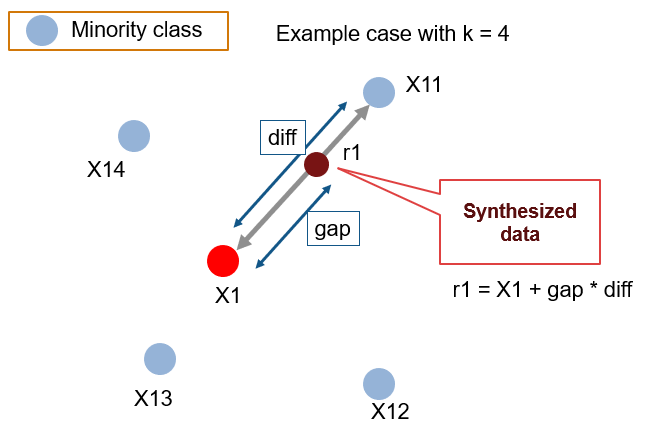

In [ ]:
# Importing packages for SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import Pipeline

from collections import Counter

In [ ]:
sm = SMOTE(sampling_strategy="auto", random_state=1234)
x_sm, y_sm = sm.fit_resample(x_train, y_train)

In [ ]:
print(Counter(y_train))
print(Counter(y_sm))

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

fig.add_trace(
    go.Pie(
        labels=list(Counter(y_train).keys()),
        values=list(Counter(y_train).values()),
        name="Original data",
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Pie(
        labels=list(Counter(y_sm).keys()),
        values=list(Counter(y_sm).values()),
        name="SMOTE data",
    ),
    row=1,
    col=2,
)

fig.update_traces(textposition="inside", hole=0.4, hoverinfo="value+percent+name")
fig.update_layout(
    title_text="Class distribution",
    # Add annotations in the center of the donut pies.
    annotations=[
        dict(text="Original", x=0.16, y=0.5, font_size=12, showarrow=False),
        dict(text="SMOTE", x=0.82, y=0.5, font_size=12, showarrow=False),
    ],
)
fig.show()

In [ ]:
over = BorderlineSMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.6)

steps = [("o", over), ("u", under)]

In [ ]:
pipeline = Pipeline(steps=steps)

# transform the dataset
x_sm_us, y_sm_us = pipeline.fit_resample(x_train, y_train)

print(Counter(y_train))
print(Counter(y_sm_us))

In [ ]:
list(Counter(y_train).keys())

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

fig.add_trace(
    go.Pie(
        labels=list(Counter(y_train).keys()),
        values=list(Counter(y_train).values()),
        name="Original Data",
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Pie(
        labels=list(Counter(y_sm_us).keys()),
        values=list(Counter(y_sm_us).values()),
        name="SMOTE and US data",
    ),
    row=1,
    col=2,
)

fig.update_traces(textposition="inside", hole=0.4, hoverinfo="percent+name+value")
fig.update_layout(
    title_text="Class distribution",
    # Add annotations in the center of the donut pies.
    annotations=[
        dict(text="Original", x=0.16, y=0.5, font_size=12, showarrow=False),
        dict(text="SMOTE and UnderSample", x=0.9, y=0.5, font_size=12, showarrow=False),
    ],
)
fig.show()

## 3.1 Lets try model a model with SMOTE data

In [ ]:
classifier = XGBClassifier(random_state=1234)
classifier.fit(x_sm, y_sm)

In [ ]:
# Predicting the test set
y_pred = classifier.predict(x_test)

# Making the confusion matrix and calculating accuracy score
accuracy = metrics.accuracy_score(y_test, y_pred)
print(accuracy)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)

As we can see, **with SMOTE we have improved the AUC** .

In [ ]:
classifier = XGBClassifier(random_state=1234)
classifier.fit(x_sm_us, y_sm_us)

In [ ]:
# Predicting the test set
y_pred = classifier.predict(x_test)

# Making the confusion matrix and calculating accuracy score
accuracy = metrics.accuracy_score(y_test, y_pred)
print(accuracy)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)

As we can see, **with SMOTE and Random Undersaampling we have improved the AUC** .

## 3.2 Generate new DataFrame with SMOTE and UnderSampling data

In [ ]:
# Names of the independent variables
feature_names = list(df.drop("class", axis=1).columns)

In [ ]:
# Concatenate train (with resampling) and test sets to build the new dataframe
sm_us_x = np.concatenate((x_sm_us, x_test))
sm_us_y = np.concatenate((y_sm_us, y_test))

In [ ]:
sm_us_df = pd.DataFrame(
    np.column_stack([sm_us_y, sm_us_x]), columns=["class"] + feature_names
)
sm_us_df.head()

# 4. Feature Selection

Now we are going to select the top features for the model (because we have done One-Hot-Encoding and there are to many variables at the moment).
There are different ways to do this:
* **PCA**: To select the top features
* **Train a model**: select the top importance variables for a simple tree
* etc

We are going to use the second choice

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=1234)
rf_clf.fit(x_sm_us, y_sm_us)

In [ ]:
rf_clf.feature_importances_

In [ ]:
features_to_plot = 25

importances = rf_clf.feature_importances_
indices = np.argsort(importances)

best_vars = np.array(feature_names)[indices][-features_to_plot:]
values = importances[indices][-features_to_plot:]
best_vars

In [ ]:
y_ticks = np.arange(0, features_to_plot)
fig, ax = plt.subplots()
ax.barh(y_ticks, values)
ax.set_yticklabels(best_vars)
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.show()

As we can see in the feature importance plot, the first 4 variables have the most importance in the model, but we are going to retireve the first 20 to be safe about over-fitting and under-fitting.

In [ ]:
best_vars = best_vars[-20:]
best_vars

# 5. Machine Learning | H2O

Now, with the resampled dataset and the selected feaures, we are going to train an xgboost model and search the best parameters

In [ ]:
from h2o.automl import H2OAutoML

h2o.init()

In [ ]:
hf = h2o.H2OFrame(sm_us_df[["class"] + list(best_vars)])
hf.head()

In [ ]:
hf["class"] = hf["class"].asfactor()
predictors = hf.drop("class").columns
response = "class"

In [ ]:
# Split into train and test
train, valid = hf.split_frame(ratios=[0.8], seed=1234)

## 5.1 H2O AutoML

We are going to try to execute AutoML with H2O on the resampled dataset and only with the final variables

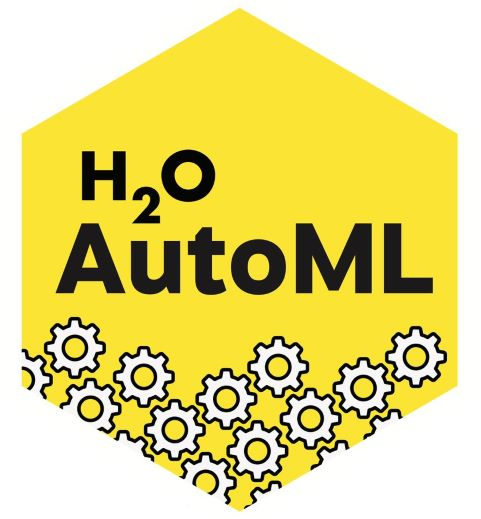

In [ ]:
# Add a Stopping Creterias: max number of models and max time
# We are going to exclude DeepLearning algorithms because they are too slow
aml = H2OAutoML(
    max_models=20, max_runtime_secs=300, seed=1234, exclude_algos=["DeepLearning"]
)

In [ ]:
# Train the model
aml.train(x=predictors, y=response, training_frame=train, validation_frame=valid)

In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=5)  # Print the first 5 rows

In [ ]:
lb = lb.as_data_frame()
lb["model_type"] = lb["model_id"].apply(lambda x: x.split("_")[0])
fig = px.bar(lb, x="model_id", y="auc", color="model_type")
# fig.update_yaxes(range=[0.999, 1])
fig.show()

In [ ]:
print("The model performance in Accuracy: {}".format(aml.leader.accuracy(valid=True)))
print("The model performance in AUC: {}".format(aml.leader.auc(valid=True)))

In [ ]:
lb = aml.leaderboard
lb

In [ ]:
# Get GBM model
m = h2o.get_model(lb[1, "model_id"])

In [ ]:
m.varimp_plot(num_of_features=10)

As we can see in the the Variable Importance plot, the top vars are much the same as they were in the [Feature Selection](#4.-feature-selection) part.

In [ ]:
m.shap_summary_plot(valid)

### SHAP Values

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

> Shapley values calculate the importance of a feature by comparing what a model predicts with and without the feature. However, since the order in which a model sees features can affect its predictions, this is done in every possible order, so that the features are fairly compared.

Imagine a sales score model. A customer living in zip code "A1" with "10 purchases" arrives and its score is 95%, while other from zip code "A2" and "7 purchases" has a score of 60%.

Each variable had its contribution to the final score. Maybe a slight change in the number of purchases changes the score a lot, while changing the zip code only contributes a tiny amount on that specific customer.

SHAP measures the impact of variables taking into account the interaction with other variables.

But i think that the best way to understand it is with [Kaggle Own Notebook](https://www.kaggle.com/dansbecker/shap-values) and [Python SHAP implementation Github](https://github.com/slundberg/shap).

# References

https://github.com/tamjid-ahsan/capstone_customer_churn/blob/main/analysis.ipynb

https://www.kaggle.com/code/andreshg/churn-prediction-0-99-auc-h2o-sklearn-smote/notebook#4.-Feature-Selection
